**DO NOT EDIT THIS FILE WITHIN THE /TSDS FOLDER - YOU RISK OVERWRITING YOUR WORK THE NEXT TIME YOU PULL FROM THE GITHUB REPOSITORY**

# Assignment 2


### Practical info
* Handin in absalon. The deadline is the 2nd of April (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 5 (Networks #1)


In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns 

import networkx as nx           # pip install networkx
import pandas as pd
import numpy as np 
import community

import json
from collections import Counter
from netwulf import visualize   # pip install netwulf

> **Ex. 5.1.3**: Another very famous type of synthetic network is the Barabási–Albert (BA) network.
1. Describe what a BA network is and how to create one.
2. On the [`NetworkX` documentations site](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html), find a method you can use for generating a BA network. Create one with $N=100$ nodes and number of new edges from each new node $m=2$.
3. Plot the network
4. Visualize the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) of your newly created BA graph.
5. Explain the main difference(s) you observe, when comparing to the ER network.
6. Are there other measures we could have used to describe the ER and BA networks further?

In [2]:
# [Answer to ex 5.1.3 here]
# The BA network is a random scale free network (read wikipedia)
G = nx.barabasi_albert_graph(100, m=2)

/home/kristian/Documents/environments/tsds_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


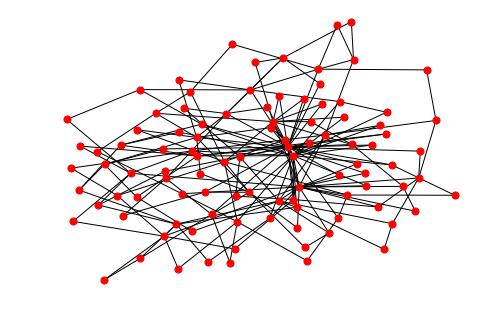

In [3]:
nx.draw(G, node_size = 50)
plt.show()

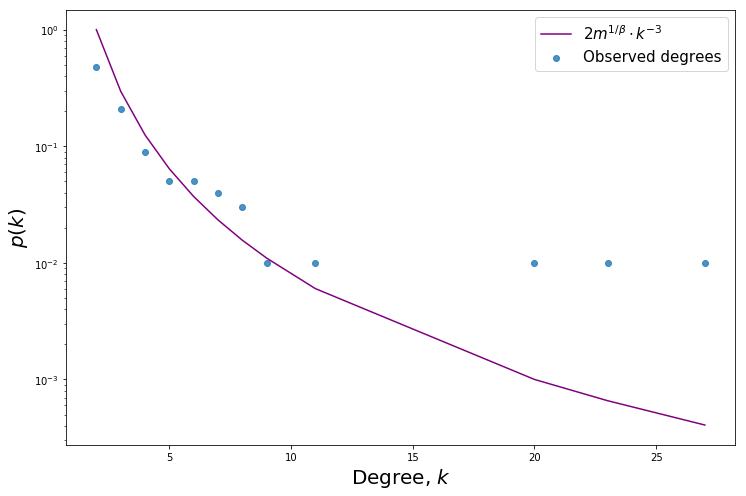

In [4]:
def p_k(k, m = 2, beta = 1/2):
    ' Theoretical degree density of BA network '
    return 2*m**(1 / beta) * k**(-3)
    

def makeDegrees(G):
    ' Generate degree distribution and expected dist.'
    hist = nx.degree_histogram(G)
    degrees = {i: x / sum(hist) for i,x in enumerate(hist) if x > 0} 
    
    expected = [p_k(k) for k in degrees]
    
    return degrees.keys(), degrees.values(), expected


def figure(x, y, exp):
    ' plot it '
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x, y, alpha = .8, label = 'Observed degrees')
    ax.plot(x, exp, color = 'purple', label = r"$2m^{1 / \beta} \cdot k^{-3}$")

    ax.set_yscale('log')

    ax.set_xlabel('Degree, $k$', fontsize = 20)
    ax.set_ylabel('$p(k)$', fontsize = 20)

    ax.legend(fontsize = 15)
    return fig 


x, y, exp = makeDegrees(G)
figure(x,y,exp)
plt.show()

> **Ex: 5.2.2**: Since it's a directed network, there are two degree distributions we can plot: one for the
in-degrees and another for the out-degrees. Plot them both in the same figure (remember to add a legend).
The distribution is very heavy-tailed, so you may want to log-scale both axes. Comment on the result. Does
it resemble any of the network models you know?
>
> *Hint: use `Counter` to count how many times each degree-value occurs and then scatter plot the degree-values
against counts. When you log-scale the axes, zero values cause trouble, so you should remove the data point for
degree 0.*

In [5]:
# SETUP CODE
# Download the data from here:
# http://socialnetworks.mpi-sws.org/data-wosn2009.html
# and place it in the working directory.

data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

data.head(10)


def get_network_slice(t0, t1):
    data_t = data.loc[data.timestamp.between(t0, t1)]
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')
    return nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.DiGraph)


G_t = get_network_slice(data.timestamp.max() - 86400 * 365, data.timestamp.max())

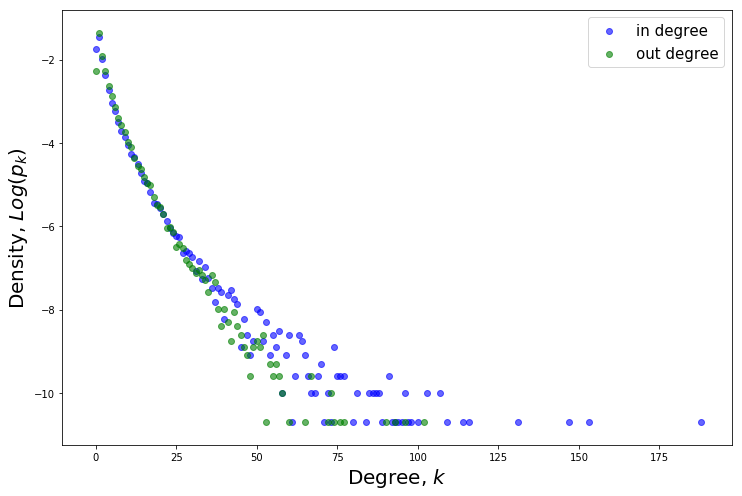

In [6]:
# [Answer to ex. 5.2.2. here]
def inOutDegree(G, which):
    ' Calculate either in or out degree '
    if which == 'in':
        cnt = Counter(dict(G.in_degree()).values())
    elif which == 'out':
        cnt = Counter(dict(G.out_degree()).values())        
    else:
        raise ValueError("which must be 'in' or 'out'")
        
    total = sum(cnt.values())
    degree_density = {i: x / total for i,x in cnt.items()}
    
    return list(degree_density.keys()), list(degree_density.values())


def figure2(x_in, y_in, x_out, y_out):
    ' figure 2'
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x_in, np.log(y_in), color = 'blue', alpha = .6, label = 'in degree')
    ax.scatter(x_out, np.log(y_out), color = 'green', alpha = .6, label = 'out degree')

    ax.set_ylabel(r'Density, $Log(p_k)$', fontsize = 20)
    ax.set_xlabel(r'Degree, $k$', fontsize = 20)

    ax.legend(fontsize = 15)
    
    
inn = inOutDegree(G_t, 'in')
out = inOutDegree(G_t, 'out')

figure2(*inn, *out)

<br>
<br>
<br>
<br>

# Questions from exercise set 6 (Networks #2)

In [7]:
# Threshold edge weight at 1
G_t.remove_edges_from([e for e in G_t.edges(data=True) if e[2]['weight'] <= 1])

# Threshold node strength at 2
thr = 10
num_nodes = len(G_t)
num_edges = len(G_t.edges())
while len([n for n in G_t.nodes() if G_t.degree(n, weight='weight') < thr]) > 0:
    G_t.remove_nodes_from([n for n in G_t.nodes() if G_t.in_degree(n, weight='weight') < thr])
    G_t.remove_nodes_from([n for n in G_t.nodes() if G_t.out_degree(n, weight='weight') < thr])
    print("removed", num_nodes - len(G_t), "nodes and", num_edges - len(G_t.edges()), "edges")
    num_nodes = len(G_t)
    num_edges = len(G_t.edges())

print("final graph has:")
print("nodes", len(G_t))
print("edges", len(G_t.edges()))

G_t = nx.Graph(G_t)

removed 38134 nodes and 51858 edges
removed 1271 nodes and 4803 edges
removed 222 nodes and 906 edges
removed 44 nodes and 188 edges
final graph has:
nodes 4726
edges 23340


> **Ex. 6.1.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [8]:
# [Answer to ex. 6.1.4 here]
partition = community.best_partition(G_t)  # dict of node-community pairs
nx.set_node_attributes(G_t, partition, 'group')

In [9]:
print(f"There are {len(set(partition.values()) )} clusters.")

There are 172 clusters.


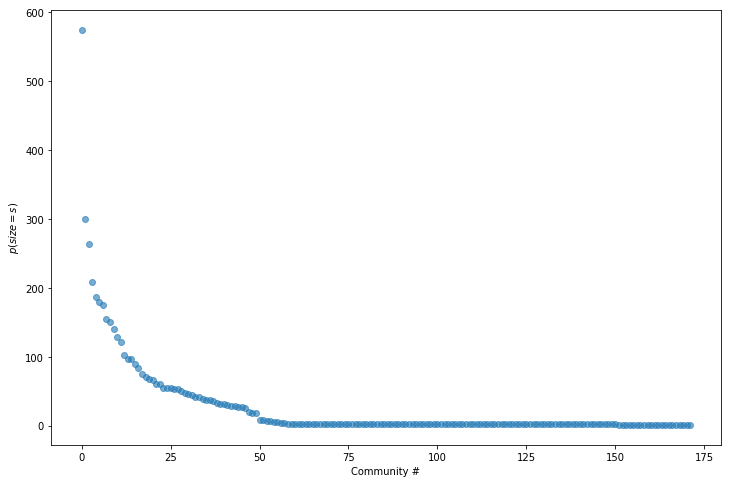

In [10]:
import operator 

def getPartitionDensity(partition):
    x = Counter(partition.values())
    density = {i: k for i,k in x.items()}
    
    sorted_t = sorted(density.items(), key=operator.itemgetter(1), reverse=True)    
    return range(len(x)), [i[1] for i in sorted_t]


def figure3(x,y):
    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(1,1,1)

    ax.scatter(x, y, alpha = .6)
    ax.set_xlabel('Community #')
    ax.set_ylabel(r'$p(size = s)$')
    return ax 


x,y = getPartitionDensity(partition)
figure3(x,y)

> **Ex. 6.1.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://github.com/benmaier/netwulf#attributes)'s an example of how to use `netwulf` with labels. Also, fiddle around with the layout a little it always makes the network look nicer.*

In [11]:
# [Answer to ex. 6.1.5 here]
#visualize(G_t)

<br>
<br>
<br>
<br>

# Questions from exercise set 7 (Networks #3)

In [12]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf

# Load data
df = pd.read_csv('peer_effects_room.csv')

room_persons = df.groupby('room').person.unique()

df['room_persons'] = df.room.map(room_persons)
df['person_other'] = df.apply(lambda row: np.setdiff1d(row['room_persons'], row['person'])[0], axis=1)

df.head()

,person,room,high_school_GPA,college_GPA,room_persons,person_other
0,0,351,-1.715472,-1.285307,"[0, 1645]",1645
1,1,738,-0.530190,-0.031833,"[1, 1039]",1039
2,2,247,-0.589543,-0.203230,"[2, 944]",944
3,3,751,-1.303115,0.982488,"[3, 1099]",1099
4,4,698,0.156678,-0.371632,"[4, 1708]",1708


> **Ex. 7.1.4:** Plot high school GPA vs roommate's high school GPA. Comment on the output. Run a regresion of high school GPA on roommate's high school GPA to formally check random assignment.
>
>> *Hint*: To run regressions in python, you can use the `statsmodels` package. Look up it's documentation and use the `.formula` api to estimate your model. To see a summary of a fitted model you can call `.summary()` on the object. 
>
>> *Hint:* Under random assignment we would expect there to be no relation between the high school GPA's of roommates. Why is this? 

In [13]:
# [Answer to ex. 7.1.4 here]
# Skipped

Having checked the data we move on to analyzing peer effects. We begin with analyzing **exogenous** peer effects. I.e. peer effects that are related to the ex ante characteristics of the roommate.

> **Ex. 7.1.5:** Plot own GPA in college vs. roommate GPA in high school. Comment on the output. Test whether there is an impact using a regresion of college school GPA on high school GPA for the person itself and its roommate.

In [14]:
# [Answer to ex. 7.1.5 here]
# Skipped

<br>
<br>
<br>
<br>

# Questions from exercise set 8 (Networks #4)

In [15]:
import networkx as nx
import numpy as np
import pandas as pd

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

el['time'] = \
    pd.to_datetime(el.timestamp,unit='s')\
        .dt.tz_localize('UTC')\
        .dt.tz_convert('Europe/Paris')

el_agg =  el\
        .groupby(['u1', 'u2'])\
        .size()\
        .rename('meet_count')\
        .pipe(lambda s: s[s>=15])\
        .reset_index()

for u in '1', '2':
    for v in 'class', 'gender':        
        s = el_agg['u'+u].map(ind[v])
        el_agg[v+u] = s


el_agg_same = el_agg[el_agg.class1==el_agg.class2]



> **Ex. 8.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


In [16]:
# [Answer to ex. 8.1.3 here]

def make_net(el_, nodes):
    nx_input = el_, 'u1', 'u2', 'meet_count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g


from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 8.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [17]:
# [Answer to ex. 8.1.5 here]
print('Overall mean', round(fraction_triangles(el_agg, ind.index),5),'\n')

el_agg_same = el_agg[el_agg.class1==el_agg.class2]


i_dict = dict(tuple(ind.groupby('class')))
el_dict = dict(tuple(el_agg_same.groupby('class1')))
classes = el_agg_same.class1.unique()

frac_t = []
for c in classes:          
    f = fraction_triangles(el_ = el_dict[c], 
                           nodes = i_dict[c].index)
    frac_t.append(f)
    
frac_t_arr = pd.Series(frac_t)    

print('Within class mean', round(frac_t_arr.mean(),5))
std = np.std([frac_t_arr.sample(frac=1,replace=True).mean() for _ in range(10000)])
print('Within class std. error of mean', round(std,5),'\n')

print('The rate of triangles within classes are much higher (> 50 times).',
      '\nThis makes sense because they share class room togeher.')


def edge_active_potential(el_, nodes):        
    a = el_.shape[0]    
    n_ = len(nodes)
    p = n_*(n_-1)/2
    return a, p



el_agg_same2 = el_agg_same[el_agg_same.gender1==el_agg_same.gender2]

el_dict2 = dict(tuple(el_agg_same2.groupby(['class1', 'gender1'])))
i_dict2 = dict(tuple(ind.groupby(['class', 'gender'])))

f_all = pd.Series(np.zeros(9))
f_same = pd.Series(np.zeros(9))

for i, c in enumerate(classes):      
    a_all, p_all = edge_active_potential(el_dict[c], i_dict[c])    
    f_all[i] = a_all/p_all
    
    p_same, a_same = 0, 0 
    for g in 'M', 'F':
        a_same_, p_same_ = \
            edge_active_potential(el_dict2[(c,g)], i_dict2[(c,g)])
        
        p_same += p_same_
        a_same += a_same_
    f_same[i] = a_same/p_same
    
        
inbreed = (f_same-f_all)/(1-f_all)

print('Within class mean', round(inbreed.mean(),4))
test = 1-np.mean([inbreed.sample(frac=1,replace=True).mean()>0 for _ in range(10000)])
print('Test for gender inbreeding homophily, reject null with p=', round(test,4),'\n')

Overall mean 0.0003 

Within class mean 0.02211
Within class std. error of mean 0.00279 

The rate of triangles within classes are much higher (> 50 times). 
This makes sense because they share class room togeher.
Within class mean 0.0282
Test for gender inbreeding homophily, reject null with p= 0.0001 

